Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Barlow-Twins Pre-training Image Tutorial with the MedMNIST Dataset

In this tutorial, we introduce an end-to-end training and evaluation example based on the PneumoniaMNIST dataset.

We'll go through the following steps:
* Pretrain a ResNet50 on PneumoniaMNIST dataset through the Barlow Twins framework.
* Fine-tune on the classification task.
* Compare performances w/ and w/o the pretraining.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com%/github/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb)

## Setup  environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import medmnist" || pip install -q medmnist
%matplotlib inline

## Setup imports

In [1]:
from collections import defaultdict
import os
import torch
import torch.nn as nn
import torch.optim as optim
from medmnist import PneumoniaMNIST
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from monai.losses.barlow_twins import BarlowTwinsLoss
from monai.networks.nets import resnet50
from monai.transforms import (
    Compose,
    CopyItemsd,
    NormalizeIntensityd,
    OneOf,
    RandCoarseDropoutd,
    RandCoarseShuffled,
    RandSpatialCropd
)
print_config()

MONAI version: 1.3.0+93.g77d43653
Numpy version: 1.24.0
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 77d436538bd7b3be7764430f7ab099e0994e1a6f
MONAI __file__: /home/<username>/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.14.1+cu117
tqdm version: 4.66.2
lmdb version: 1.4.1
psutil version: 5.9.8
pandas version: 2.2.1
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.11.1
pynrrd version: 1.0.0
clearml version: 1.14.5rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set deterministic training for reproducibility

In [2]:
set_determinism(seed=0)

# Define transforms and datasets

In [3]:
# Define Training Transforms
train_transforms = Compose(
    [ 
        NormalizeIntensityd(keys=['image'], nonzero=True),
        CopyItemsd(keys=["image"], times=1, names=["image_2"], allow_missing_keys=False),
        RandSpatialCropd(keys=["image"], roi_size=(72, 72)),
        RandSpatialCropd(keys=["image_2"], roi_size=(72, 72)),
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=32
                ),
                RandCoarseDropoutd(
                    keys=["image"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=64
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image"], prob=0.8, holes=10, spatial_size=8),
        # Please note that that if image, image_2 are called via the same transform call because of the determinism
        # they will get augmented the exact same way which is not the required case here, hence two calls are made
        OneOf(
            transforms=[
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=5, dropout_holes=True, max_spatial_size=32
                ),
                RandCoarseDropoutd(
                    keys=["image_2"], prob=1.0, holes=6, spatial_size=20, dropout_holes=False, max_spatial_size=64
                ),
            ]
        ),
        RandCoarseShuffled(keys=["image_2"], prob=0.8, holes=10, spatial_size=8),
    ]
)

In [4]:
train_dataset = PneumoniaMNIST(split="train", download=True, size=128)
val_dataset = PneumoniaMNIST(split="val", download=True, size=128)
test_dataset = PneumoniaMNIST(split="test", download=True, size=128)

Using downloaded and verified file: /home/lucas.robinet/.medmnist/pneumoniamnist_128.npz
Using downloaded and verified file: /home/lucas.robinet/.medmnist/pneumoniamnist_128.npz
Using downloaded and verified file: /home/lucas.robinet/.medmnist/pneumoniamnist_128.npz


In [5]:
class SelfSupervisedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms):
        self.dataset = dataset
        self.transforms = transforms
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = {'image': np.array(self.dataset[idx][0]).reshape(1, 128, 128)}
        item = self.transforms(item)
        return item

## Define model

In [6]:
model = resnet50(spatial_dims=2, n_input_channels=1)
model.fc = nn.Sequential(
            nn.Linear(2048, 2048),  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(2048, 512))
sum(p.numel() for p in model.parameters() if p.requires_grad)

28751040

# Self-supervised training with Barlow Twins Loss

In [7]:
device = torch.device("cuda:0")
logdir = os.path.normpath("to/be/changed")
batch_size = 128
epochs = 200
lr = 1e-3
loss_fn = BarlowTwinsLoss(lambd=5e-3)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5, verbose=True)
model = model.to(device)

In [8]:
train_dataset = SelfSupervisedDataset(train_dataset, transforms=train_transforms)
val_dataset = SelfSupervisedDataset(val_dataset, transforms=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
metrics = defaultdict(list)
best_loss = np.infty
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print("-" * 10)
    model.train()
    metrics["lr"].append(optimizer.state_dict()["param_groups"][0]["lr"])
    epoch_loss = 0.
    
    for batch_data in tqdm.tqdm(train_loader, desc="Training..."):
        inputs, inputs_2 = (batch_data["image"].to(device), batch_data["image_2"].to(device))
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs_2 = model(inputs_2)

        loss = loss_fn(outputs, outputs_2)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.shape[0]

    epoch_loss /= len(train_loader.dataset)
    print(f"Training loss: {epoch_loss:.4f}")
        
    metrics["train/loss"].append(epoch_loss)
    model.eval()
    with torch.no_grad():
        val_loss = 0.
        for batch_data in tqdm.tqdm(val_loader, desc="Validation..."):
            inputs, inputs_2 = (batch_data["image"].to(device), batch_data["image_2"].to(device))
            outputs = model(inputs)
            outputs_2 = model(inputs_2)

            loss = loss_fn(outputs, outputs_2)
            val_loss += loss.item() * inputs.shape[0]
        
    val_loss /= len(val_loader.dataset)
    print(f"Validation loss: {val_loss:.4f}")
            
    metrics["val/loss"].append(val_loss)


    scheduler.step(metrics["val/loss"][-1])
    if metrics["val/loss"][-1] < best_loss:
        best_loss = metrics["val/loss"][-1]
        torch.save(model.state_dict(), os.path.join(logdir, 'best_model.pth'))




Epoch 1/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.69it/s]


Training loss: 414.9139


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.04it/s]


Validation loss: 382.6324
Epoch 2/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 321.3911


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Validation loss: 312.3366
Epoch 3/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.74it/s]


Training loss: 304.8620


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.74it/s]


Validation loss: 325.1334
Epoch 4/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.85it/s]


Training loss: 307.6505


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.85it/s]


Validation loss: 307.9882
Epoch 5/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.78it/s]


Training loss: 300.2796


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


Validation loss: 307.9189
Epoch 6/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.85it/s]


Training loss: 302.4158


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Validation loss: 318.8146
Epoch 7/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 302.6410


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.63it/s]


Validation loss: 305.9608
Epoch 8/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 302.7499


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.19it/s]


Validation loss: 307.3587
Epoch 9/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 302.6879


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]


Validation loss: 337.2182
Epoch 10/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 301.6817


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Validation loss: 305.4803
Epoch 11/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 301.8508


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


Validation loss: 300.7874
Epoch 12/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 300.9300


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


Validation loss: 304.7666
Epoch 13/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.88it/s]


Training loss: 293.0790


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


Validation loss: 278.5346
Epoch 14/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 277.3384


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 264.0489
Epoch 15/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 264.9702


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


Validation loss: 314.6404
Epoch 16/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 253.9816


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.69it/s]


Validation loss: 259.3910
Epoch 17/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 253.3263


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Validation loss: 249.5530
Epoch 18/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 247.2622


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


Validation loss: 263.1238
Epoch 19/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 239.8596


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.85it/s]


Validation loss: 232.1883
Epoch 20/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.78it/s]


Training loss: 223.7333


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.07it/s]


Validation loss: 228.2665
Epoch 21/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 215.6478


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Validation loss: 223.7940
Epoch 22/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 214.6377


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


Validation loss: 239.4974
Epoch 23/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 211.2786


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Validation loss: 215.1015
Epoch 24/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 213.4887


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


Validation loss: 213.9874
Epoch 25/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 209.0818


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.18it/s]


Validation loss: 210.1655
Epoch 26/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 198.5380


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Validation loss: 195.7411
Epoch 27/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 191.0238


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Validation loss: 189.9852
Epoch 28/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 185.9969


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.04it/s]


Validation loss: 185.4953
Epoch 29/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.72it/s]


Training loss: 181.1212


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


Validation loss: 195.7114
Epoch 30/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 171.9451


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Validation loss: 190.1561
Epoch 31/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 169.1259


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Validation loss: 191.0076
Epoch 32/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 169.4089


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


Validation loss: 174.6208
Epoch 33/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 165.5861


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Validation loss: 171.8678
Epoch 34/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 163.3959


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.72it/s]


Validation loss: 177.0472
Epoch 35/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 163.1541


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.04it/s]


Validation loss: 169.0154
Epoch 36/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 163.2930


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.09it/s]


Validation loss: 168.1640
Epoch 37/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.78it/s]


Training loss: 161.8464


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.03it/s]


Validation loss: 163.4611
Epoch 38/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 162.2965


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.09it/s]


Validation loss: 187.4346
Epoch 39/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 163.3259


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.69it/s]


Validation loss: 176.7997
Epoch 40/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 160.2268


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.09it/s]


Validation loss: 166.9997
Epoch 41/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.78it/s]


Training loss: 156.4519


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.95it/s]


Validation loss: 193.7098
Epoch 42/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.85it/s]


Training loss: 150.8664


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Validation loss: 159.4611
Epoch 43/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.73it/s]


Training loss: 153.5690


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


Validation loss: 184.2258
Epoch 44/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 149.8157


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.18it/s]


Validation loss: 156.4544
Epoch 45/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 147.4994


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.85it/s]


Validation loss: 150.3279
Epoch 46/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 147.4801


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Validation loss: 177.5727
Epoch 47/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 144.9211


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Validation loss: 151.1668
Epoch 48/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.76it/s]


Training loss: 141.0570


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Validation loss: 142.7724
Epoch 49/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 139.5581


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.64it/s]


Validation loss: 153.7417
Epoch 50/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 137.0874


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.16it/s]


Validation loss: 138.8799
Epoch 51/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.71it/s]


Training loss: 139.7105


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


Validation loss: 157.3969
Epoch 52/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 137.3776


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.69it/s]


Validation loss: 143.6432
Epoch 53/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 132.4483


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Validation loss: 134.7175
Epoch 54/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.76it/s]


Training loss: 126.4073


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.05it/s]


Validation loss: 142.3626
Epoch 55/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 124.3608


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 133.5520
Epoch 56/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.76it/s]


Training loss: 125.5602


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


Validation loss: 166.5702
Epoch 57/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 122.3987


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Validation loss: 125.1112
Epoch 58/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.85it/s]


Training loss: 119.1053


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.07it/s]


Validation loss: 124.1189
Epoch 59/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 113.8826


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Validation loss: 125.8866
Epoch 60/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 109.0925


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Validation loss: 113.6546
Epoch 61/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.76it/s]


Training loss: 105.0820


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


Validation loss: 123.7877
Epoch 62/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 106.6442


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 108.9623
Epoch 63/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 102.1264


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 113.6336
Epoch 64/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 100.1844


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.09it/s]


Validation loss: 109.1470
Epoch 65/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 98.5201


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 112.6324
Epoch 66/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 100.3719


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.02it/s]


Validation loss: 103.8103
Epoch 67/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 97.4509


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Validation loss: 100.7742
Epoch 68/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 94.1304


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Validation loss: 104.0089
Epoch 69/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.71it/s]


Training loss: 91.4698


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.66it/s]


Validation loss: 94.8621
Epoch 70/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 88.9085


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


Validation loss: 93.4974
Epoch 71/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 87.2551


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.16it/s]


Validation loss: 93.6501
Epoch 72/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.88it/s]


Training loss: 84.0707


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.21it/s]


Validation loss: 127.1414
Epoch 73/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 86.4161


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Validation loss: 141.5529
Epoch 74/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.87it/s]


Training loss: 82.6235


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Validation loss: 93.1381
Epoch 75/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.72it/s]


Training loss: 80.0814


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Validation loss: 92.5471
Epoch 76/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 80.5755


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


Validation loss: 91.7014
Epoch 77/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.78it/s]


Training loss: 78.5656


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.04it/s]


Validation loss: 86.8952
Epoch 78/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:22<00:00,  1.68it/s]


Training loss: 76.8399


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Validation loss: 123.2604
Epoch 79/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 76.3819


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Validation loss: 85.8532
Epoch 80/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 74.3321


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.09it/s]


Validation loss: 87.1544
Epoch 81/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 74.4686


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


Validation loss: 82.8835
Epoch 82/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 73.4899


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Validation loss: 83.4786
Epoch 83/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 73.2851


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Validation loss: 88.0454
Epoch 84/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 71.6188


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.73it/s]


Validation loss: 94.9008
Epoch 85/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 70.6582


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.19it/s]


Validation loss: 77.6760
Epoch 86/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 69.4330


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.76it/s]


Validation loss: 90.2681
Epoch 87/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 69.6552


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.82it/s]


Validation loss: 78.6530
Epoch 88/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.71it/s]


Training loss: 68.6395


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


Validation loss: 82.4713
Epoch 89/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 68.6889


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Validation loss: 83.9211
Epoch 90/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.78it/s]


Training loss: 68.7556


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


Validation loss: 82.4076
Epoch 91/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 67.0407


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


Validation loss: 77.2115
Epoch 92/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.73it/s]


Training loss: 66.6696


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 73.2150
Epoch 93/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 64.8504


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


Validation loss: 77.0577
Epoch 94/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 65.4562


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 83.5244
Epoch 95/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 63.8953


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


Validation loss: 81.2949
Epoch 96/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 63.2045


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


Validation loss: 72.7511
Epoch 97/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 61.1535


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


Validation loss: 70.5432
Epoch 98/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.78it/s]


Training loss: 61.8401


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Validation loss: 68.2925
Epoch 99/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 62.0267


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


Validation loss: 70.8259
Epoch 100/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 61.7983


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.64it/s]


Validation loss: 70.5095
Epoch 101/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.72it/s]


Training loss: 61.9953


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Validation loss: 69.7155
Epoch 102/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 60.8385


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.05it/s]


Validation loss: 66.8818
Epoch 103/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 58.8831


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.18it/s]


Validation loss: 66.1663
Epoch 104/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 59.1276


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.03it/s]


Validation loss: 67.8550
Epoch 105/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 57.8147


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Validation loss: 63.9801
Epoch 106/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 56.9536


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Validation loss: 71.8132
Epoch 107/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.87it/s]


Training loss: 57.8059


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


Validation loss: 73.3939
Epoch 108/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 56.9194


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


Validation loss: 64.1050
Epoch 109/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 58.0226


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s]


Validation loss: 64.0409
Epoch 110/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 57.3633


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


Validation loss: 66.6178
Epoch 111/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 55.4543


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.16it/s]


Validation loss: 64.7676
Epoch 112/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 57.1250


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 69.0724
Epoch 113/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.78it/s]


Training loss: 54.5274


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.21it/s]


Validation loss: 67.0276
Epoch 114/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.89it/s]


Training loss: 53.5510


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.04it/s]


Validation loss: 60.9732
Epoch 115/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 53.2425


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


Validation loss: 72.7519
Epoch 116/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 53.6866


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.02it/s]


Validation loss: 77.8742
Epoch 117/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 54.0056


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


Validation loss: 63.5437
Epoch 118/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 52.4050


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.98it/s]


Validation loss: 61.8433
Epoch 119/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 52.2839


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


Validation loss: 69.8373
Epoch 120/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 51.1678


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


Validation loss: 59.0113
Epoch 121/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.70it/s]


Training loss: 51.6429


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


Validation loss: 59.0057
Epoch 122/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 51.3359


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Validation loss: 57.8441
Epoch 123/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 50.8141


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


Validation loss: 61.8055
Epoch 124/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 49.1409


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Validation loss: 58.8391
Epoch 125/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 50.2352


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


Validation loss: 60.4113
Epoch 126/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 50.7136


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Validation loss: 61.7037
Epoch 127/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 48.8323


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


Validation loss: 56.2779
Epoch 128/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.76it/s]


Training loss: 49.2042


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Validation loss: 56.2485
Epoch 129/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 48.7452


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


Validation loss: 57.8772
Epoch 130/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 47.9511


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 57.6647
Epoch 131/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 47.3895


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]


Validation loss: 72.9315
Epoch 132/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 48.8055


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.19it/s]


Validation loss: 57.0142
Epoch 133/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 48.5470


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.06it/s]


Validation loss: 56.7028
Epoch 134/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 48.1608


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


Validation loss: 59.3024
Epoch 135/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 47.8443


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.05it/s]


Validation loss: 59.8699
Epoch 136/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.78it/s]


Training loss: 46.7761


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


Validation loss: 53.5152
Epoch 137/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 46.3887


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.85it/s]


Validation loss: 56.5692
Epoch 138/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.74it/s]


Training loss: 46.5890


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


Validation loss: 52.5240
Epoch 139/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 44.6401


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Validation loss: 54.4964
Epoch 140/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 45.1596


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


Validation loss: 55.6696
Epoch 141/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.88it/s]


Training loss: 45.4284


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.16it/s]


Validation loss: 55.6295
Epoch 142/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 43.9459


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


Validation loss: 53.4045
Epoch 143/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 44.1917


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


Validation loss: 53.9669
Epoch 144/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 43.9738


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.02it/s]


Validation loss: 52.8618
Epoch 145/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.74it/s]


Training loss: 43.8726


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


Validation loss: 54.3453
Epoch 146/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 43.1945


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


Validation loss: 52.9005
Epoch 147/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 44.1945


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Validation loss: 54.6815
Epoch 148/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.87it/s]


Training loss: 43.9876


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.18it/s]


Validation loss: 51.0541
Epoch 149/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.73it/s]


Training loss: 44.3212


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.19it/s]


Validation loss: 55.5523
Epoch 150/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.88it/s]


Training loss: 43.6672


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.05it/s]


Validation loss: 52.1033
Epoch 151/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 41.9753


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


Validation loss: 52.6996
Epoch 152/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 42.6711


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.22it/s]


Validation loss: 56.4895
Epoch 153/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.87it/s]


Training loss: 42.1324


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


Validation loss: 53.0404
Epoch 154/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 42.4211


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Validation loss: 50.1436
Epoch 155/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 41.3006


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Validation loss: 49.2818
Epoch 156/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 40.6870


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.07it/s]


Validation loss: 49.3085
Epoch 157/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 40.7636


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.69it/s]


Validation loss: 49.8921
Epoch 158/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.74it/s]


Training loss: 40.5308


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.64it/s]


Validation loss: 50.7723
Epoch 159/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.75it/s]


Training loss: 39.8980


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.63it/s]


Validation loss: 53.7884
Epoch 160/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 40.6078


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.23it/s]


Validation loss: 47.8879
Epoch 161/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.91it/s]


Training loss: 39.3833


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.22it/s]


Validation loss: 49.5071
Epoch 162/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 40.2824


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


Validation loss: 48.2804
Epoch 163/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 40.5349


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.18it/s]


Validation loss: 49.2413
Epoch 164/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.84it/s]


Training loss: 39.4134


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


Validation loss: 47.0176
Epoch 165/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 40.1056


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.17it/s]


Validation loss: 47.1307
Epoch 166/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 39.3432


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.79it/s]


Validation loss: 44.4340
Epoch 167/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 38.6247


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.15it/s]


Validation loss: 48.0953
Epoch 168/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 38.9026


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Validation loss: 47.2742
Epoch 169/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.74it/s]


Training loss: 38.6138


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Validation loss: 49.6696
Epoch 170/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.78it/s]


Training loss: 38.0912


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.07it/s]


Validation loss: 51.3753
Epoch 171/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 37.8812


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


Validation loss: 44.9839
Epoch 172/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 38.9299


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


Validation loss: 43.2500
Epoch 173/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.85it/s]


Training loss: 37.7058


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Validation loss: 45.7980
Epoch 174/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.76it/s]


Training loss: 37.6329


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.07it/s]


Validation loss: 46.7663
Epoch 175/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 37.2503


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.72it/s]


Validation loss: 46.5421
Epoch 176/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 36.5955


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


Validation loss: 45.5695
Epoch 177/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 36.9792


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 45.4395
Epoch 178/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 36.4847


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


Validation loss: 45.8145
Epoch 179/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 37.1213


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Validation loss: 44.6333
Epoch 180/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 37.1502


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


Validation loss: 48.2335
Epoch 181/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 36.8689


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 45.7141
Epoch 182/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.85it/s]


Training loss: 36.4107


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 45.4562
Epoch 183/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 36.1144


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


Validation loss: 52.0289
Epoch 00183: reducing learning rate of group 0 to 1.0000e-04.
Epoch 184/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.89it/s]


Training loss: 34.4447


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


Validation loss: 39.5194
Epoch 185/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 32.8847


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


Validation loss: 38.4017
Epoch 186/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.79it/s]


Training loss: 32.5394


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


Validation loss: 39.7002
Epoch 187/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.85it/s]


Training loss: 32.5076


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Validation loss: 39.9249
Epoch 188/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.75it/s]


Training loss: 32.4170


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.76it/s]


Validation loss: 39.3239
Epoch 189/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.85it/s]


Training loss: 32.1288


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.16it/s]


Validation loss: 38.8702
Epoch 190/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Training loss: 31.7972


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 39.7403
Epoch 191/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.81it/s]


Training loss: 32.0249


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Validation loss: 39.0959
Epoch 192/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.82it/s]


Training loss: 31.4268


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Validation loss: 38.4736
Epoch 193/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:21<00:00,  1.75it/s]


Training loss: 31.3367


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


Validation loss: 39.1596
Epoch 194/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.85it/s]


Training loss: 31.7460


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Validation loss: 38.2806
Epoch 195/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 31.2817


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.74it/s]


Validation loss: 37.6750
Epoch 196/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.80it/s]


Training loss: 31.3267


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.92it/s]


Validation loss: 39.0312
Epoch 197/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.83it/s]


Training loss: 31.2601


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.09it/s]


Validation loss: 37.1770
Epoch 198/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.77it/s]


Training loss: 31.6238


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.13it/s]


Validation loss: 36.6102
Epoch 199/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.87it/s]


Training loss: 31.2399


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.05it/s]


Validation loss: 38.8868
Epoch 200/200
----------


Training...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:20<00:00,  1.76it/s]


Training loss: 31.5786


Validation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.63it/s]

Validation loss: 37.7903


[0.0001 0.001 ]


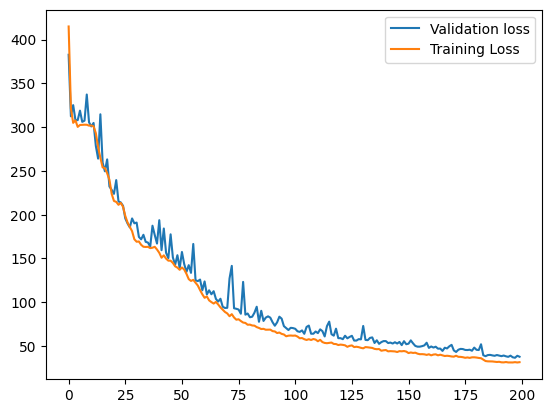

In [11]:
import matplotlib.pyplot as plt
print(np.unique(metrics['lr']))
plt.figure()
plt.plot(metrics['val/loss'], label='Validation loss')
plt.plot(metrics['train/loss'], label='Training Loss')
plt.legend()
plt.show()

# Fine-tune on classification task

In [146]:
train_dataset = PneumoniaMNIST(split="train", download=True, size=128)
val_dataset = PneumoniaMNIST(split="val", download=True, size=128)
test_dataset = PneumoniaMNIST(split="test", download=True, size=128)

Using downloaded and verified file: /home/lucas.robinet/.medmnist/pneumoniamnist_128.npz
Using downloaded and verified file: /home/lucas.robinet/.medmnist/pneumoniamnist_128.npz
Using downloaded and verified file: /home/lucas.robinet/.medmnist/pneumoniamnist_128.npz


In [147]:
transforms_classif = NormalizeIntensityd(keys=['image'], nonzero=True)

In [148]:
class ClassificationDataset(SelfSupervisedDataset):
    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = np.array(sample[0])
        label = sample[1].item()
        item = {'image': image.reshape(1, 128, 128)}
        item = self.transforms(item)
        return item['image'], label

In [149]:
train_dataset = ClassificationDataset(train_dataset, transforms=transforms_classif)
val_dataset = ClassificationDataset(val_dataset, transforms=transforms_classif)
test_dataset = ClassificationDataset(test_dataset, transforms=transforms_classif)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [150]:
model = resnet50(spatial_dims=2, n_input_channels=1)
model.fc = nn.Linear(2048, 1)
state_dict = torch.load(os.path.join(logdir, 'best_model.pth'))
model.load_state_dict(state_dict, strict=False)
model = model.to(device)

In [151]:
epochs = 5
lr = 1e-4
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [152]:
metrics = defaultdict(list)
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    print('-' * 10)

    metrics['lr'].append(optimizer.state_dict()['param_groups'][0]['lr'])
    model.train()

    running_loss_train = 0.0
    running_corrects_train = 0.0

    for inputs, labels in tqdm.tqdm(train_loader, desc='Training...', total=len(train_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(1), labels.float())
        loss.backward()
        optimizer.step()
        preds = torch.where(outputs > 0., 1., 0.)

        running_loss_train += loss.item() * inputs.size(0)
        running_corrects_train += torch.sum(preds.squeeze(1) == labels.data).item()

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    epoch_acc_train = running_corrects_train / len(train_loader.dataset)
    print(f"Train loss: {epoch_loss_train:.4f} - Acc: {epoch_acc_train:.4f}")
    metrics['train/loss'].append(epoch_loss_train)
    metrics['train/acc'].append(epoch_acc_train)
    model.eval()
    running_loss_val = 0.0
    running_corrects_val = 0.0
    for item in tqdm.tqdm(val_loader, desc='Validating...', total=len(val_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            preds = torch.where(outputs > 0., 1., 0.)
            loss = loss_fn(outputs.squeeze(1), labels.float())
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds.squeeze(1) == labels.data).item()
                

    epoch_loss_val = running_loss_val / len(val_loader.dataset)
    epoch_acc_val = running_corrects_val / len(val_loader.dataset)

    metrics['val/loss'].append(epoch_loss_val)
    metrics['val/acc'].append(epoch_acc_val)
    print(f"Validation loss: {epoch_loss_val:.4f} - Acc: {epoch_acc_val:.4f}")

Epoch 1/5
----------


Training...: 100%|██████████████████████████████| 37/37 [00:15<00:00,  2.39it/s]


Train loss: 0.3044 - Acc: 0.8825


Validating...: 100%|██████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


Validation loss: 0.0959 - Acc: 0.9351
Epoch 2/5
----------


Training...: 100%|██████████████████████████████| 37/37 [00:15<00:00,  2.39it/s]


Train loss: 0.1001 - Acc: 0.9626


Validating...: 100%|██████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


Validation loss: 0.0453 - Acc: 0.9351
Epoch 3/5
----------


Training...: 100%|██████████████████████████████| 37/37 [00:15<00:00,  2.39it/s]


Train loss: 0.0674 - Acc: 0.9775


Validating...: 100%|██████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


Validation loss: 0.0713 - Acc: 0.9351
Epoch 4/5
----------


Training...: 100%|██████████████████████████████| 37/37 [00:15<00:00,  2.39it/s]


Train loss: 0.0459 - Acc: 0.9839


Validating...: 100%|██████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


Validation loss: 0.0592 - Acc: 0.9256
Epoch 5/5
----------


Training...: 100%|██████████████████████████████| 37/37 [00:15<00:00,  2.38it/s]


Train loss: 0.0321 - Acc: 0.9902


Validating...: 100%|██████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]

Validation loss: 0.0143 - Acc: 0.9542


In [153]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

model.eval()
raw_predictions = []
true_labels = []

for inputs, labels in tqdm.tqdm(test_loader, desc='Validating...', total=len(test_loader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        raw_predictions.extend(outputs.cpu().sigmoid())
        true_labels.extend(labels.cpu())

predictions = np.hstack(raw_predictions).tolist()
true_labels = np.hstack(true_labels).tolist()
auc = roc_auc_score(true_labels, predictions)
print('AUC - ', auc)
print(classification_report(true_labels, [1 if pred > 0.5 else 0 for pred in predictions]))

Validating...: 100%|██████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]

AUC -  0.9796844181459566
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       234
           1       0.84      1.00      0.91       390

    accuracy                           0.88       624
   macro avg       0.92      0.84      0.86       624
weighted avg       0.90      0.88      0.87       624



# With no-pretraining

In [183]:
model = resnet50(spatial_dims=2, n_input_channels=1)
model.fc = nn.Linear(2048, 1)
model = model.to(device)

In [184]:
epochs = 5
lr = 1e-4
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [185]:
metrics_end_to_end = defaultdict(list)
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    print('-' * 10)

    metrics['lr'].append(optimizer.state_dict()['param_groups'][0]['lr'])
    model.train()

    running_loss_train = 0.0
    running_corrects_train = 0.0

    for inputs, labels in tqdm.tqdm(train_loader, desc='Training...', total=len(train_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(1), labels.float())
        loss.backward()
        optimizer.step()
        preds = torch.where(outputs > 0., 1., 0.)

        running_loss_train += loss.item() * inputs.size(0)
        running_corrects_train += torch.sum(preds.squeeze(1) == labels.data).item()

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    epoch_acc_train = running_corrects_train / len(train_loader.dataset)
    print(f"Train loss: {epoch_loss_train:.4f} - Acc: {epoch_acc_train:.4f}")
    metrics_end_to_end['train/loss'].append(epoch_loss_train)
    metrics_end_to_end['train/acc'].append(epoch_acc_train)
    model.eval()
    running_loss_val = 0.0
    running_corrects_val = 0.0
    for item in tqdm.tqdm(val_loader, desc='Validating...', total=len(val_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            preds = torch.where(outputs > 0., 1., 0.)
            loss = loss_fn(outputs.squeeze(1), labels.float())
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds.squeeze(1) == labels.data).item()
                

    epoch_loss_val = running_loss_val / len(val_loader.dataset)
    epoch_acc_val = running_corrects_val / len(val_loader.dataset)

    metrics_end_to_end['val/loss'].append(epoch_loss_val)
    metrics_end_to_end['val/acc'].append(epoch_acc_val)
    print(f"Validation loss: {epoch_loss_val:.4f} - Acc: {epoch_acc_val:.4f}")

Epoch 1/5
----------


Training...: 100%|██████████████████████████████| 37/37 [00:15<00:00,  2.39it/s]


Train loss: 0.2791 - Acc: 0.8802


Validating...: 100%|██████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


Validation loss: 3.7949 - Acc: 0.6679
Epoch 2/5
----------


Training...: 100%|██████████████████████████████| 37/37 [00:15<00:00,  2.39it/s]


Train loss: 0.1334 - Acc: 0.9477


Validating...: 100%|██████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


Validation loss: 0.1356 - Acc: 0.8874
Epoch 3/5
----------


Training...: 100%|██████████████████████████████| 37/37 [00:15<00:00,  2.39it/s]


Train loss: 0.0837 - Acc: 0.9696


Validating...: 100%|██████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


Validation loss: 0.1001 - Acc: 0.9065
Epoch 4/5
----------


Training...: 100%|██████████████████████████████| 37/37 [00:15<00:00,  2.39it/s]


Train loss: 0.0734 - Acc: 0.9715


Validating...: 100%|██████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


Validation loss: 2.7176 - Acc: 0.3626
Epoch 5/5
----------


Training...: 100%|██████████████████████████████| 37/37 [00:15<00:00,  2.39it/s]


Train loss: 0.0504 - Acc: 0.9809


Validating...: 100%|██████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]

Validation loss: 0.4645 - Acc: 0.8111


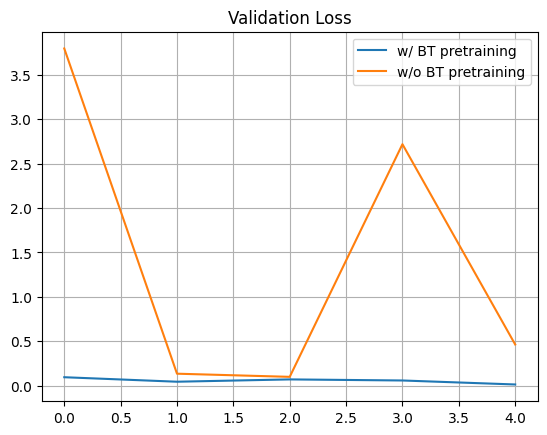

In [186]:
plt.figure()
plt.title('Validation Loss')
plt.plot(metrics['val/loss'], label='w/ BT pretraining')
plt.plot(metrics_end_to_end['val/loss'], label='w/o BT pretraining')
plt.legend()
plt.grid()
plt.show()

In [188]:
model.eval()
raw_predictions = []
true_labels = []

for inputs, labels in tqdm.tqdm(test_loader, desc='Validating...', total=len(test_loader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        raw_predictions.extend(outputs.cpu().sigmoid())
        true_labels.extend(labels.cpu())

predictions = np.hstack(raw_predictions).tolist()
true_labels = np.hstack(true_labels).tolist()
auc = roc_auc_score(true_labels, predictions)
print('AUC - ', auc)

Validating...: 100%|██████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]

AUC -  0.9503835196142889


|         | w/ BT pretraining | w/o BT pretraining |
|---------|-------------------|--------------------|
| ROC AUC | $\approx$ 0.98    | $\approx$ 0.95     |